<a href="https://colab.research.google.com/github/marissafujimoto/catmap/blob/colab-poc/notebooks/cancer_label_transfer_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Tabula Muris Tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/tabula_muris.html)

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scipy.io import mmread

In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.3.0


In [ ]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nsclc_path = "/content/drive/MyDrive/catmap/Data/refquery_final_new.h5ad"

nsclc = sc.read(nsclc_path)

In [ ]:
nsclc

AnnData object with n_obs × n_vars = 224611 × 72131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2'
    var: 'features'
    obsm: 'X_umap', 'X_umap.ref'

In [ ]:
nsclc.X[100, :].toarray()

array([[0.76055874, 5.03493207, 3.30350515, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# nsclc = nsclc[
#     (nsclc.obs.Subtype == "squamous cell carcinoma")
# ].copy()

In [ ]:
nsclc.shape

(224611, 72131)

In [ ]:
import gc

gc.collect()

101

In [ ]:
raw_counts = mmread("/content/drive/MyDrive/catmap/Data/RNA_rawcounts_matrix.mtx")

In [ ]:
raw_counts = raw_counts.T

In [ ]:
raw_counts = raw_counts.tocsr()

In [ ]:
raw_counts.shape

(224611, 72131)

In [ ]:
nsclc.X.shape

(224611, 72131)

In [ ]:
raw_counts[0, :].toarray()

array([[0., 7., 0., ..., 0., 0., 0.]])

In [ ]:
adata = nsclc
adata.layers["counts"] = raw_counts.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="Study",
    subset=True,
)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="Study")

In [ ]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [ ]:
scvi_model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [ ]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

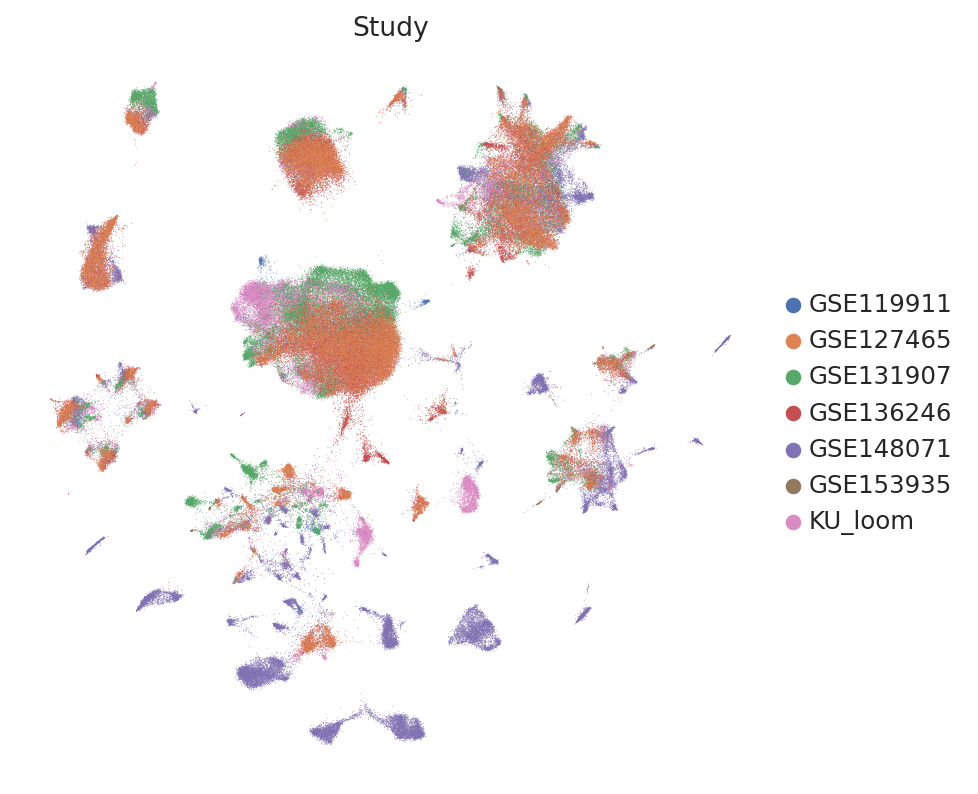

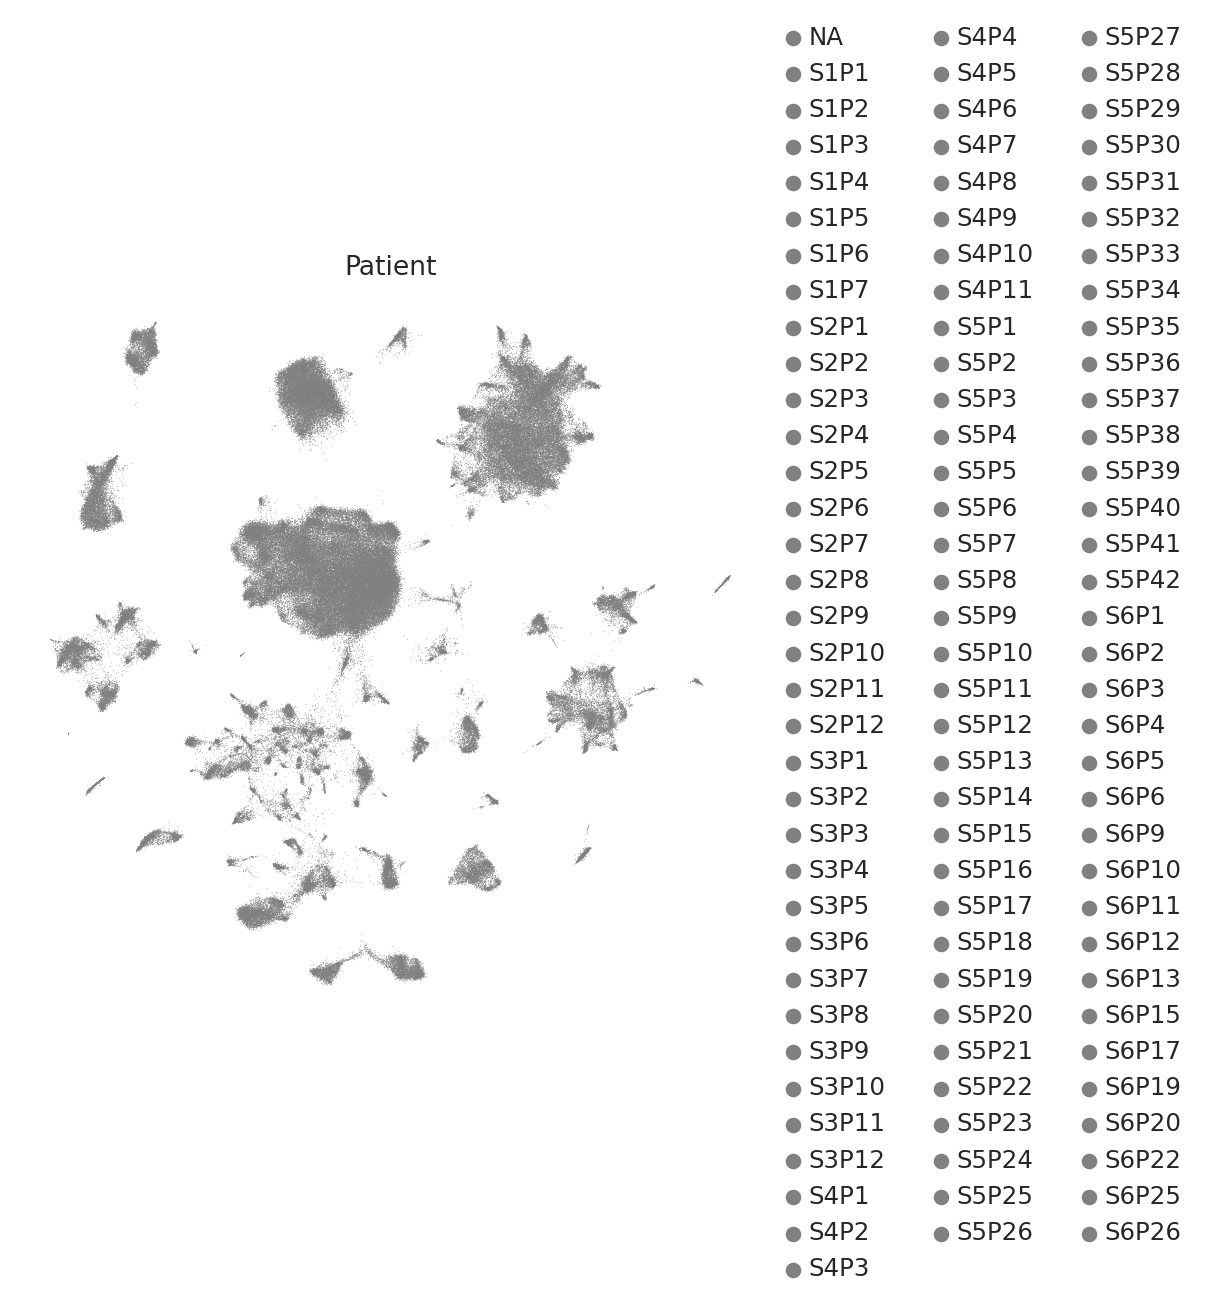

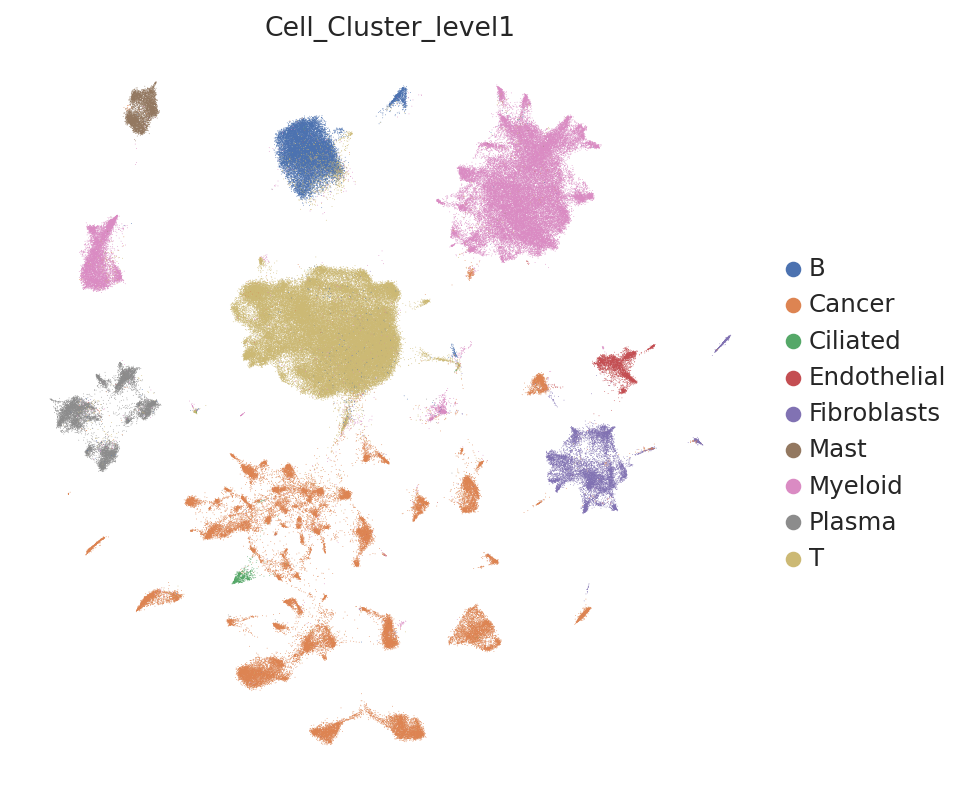

In [ ]:
sc.pl.umap(
    adata,
    color=["Study"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    adata,
    color=["Patient"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    adata,
    color=["Cell_Cluster_level1"],
    frameon=False,
    ncols=1,
)


In [ ]:
# Export UMAP coordinates to a CSV file and save to Google Drive
umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'])
umap_df['Study'] = adata.obs['Study']
umap_df['Patient'] = adata.obs['Patient']
umap_df['Cell_Cluster_level1'] = adata.obs['Cell_Cluster_level1']

# Create the directory if it doesn't exist
# output_dir = "/content/drive/MyDrive/catmap"
# os.makedirs(output_dir, exist_ok=True)

# umap_df.to_csv(os.path.join(output_dir, 'umap_coordinates.csv'), index=False)


In [ ]:
umap_df_test = pd.DataFrame(adata.obs['Study'], columns = ['Study'])
umap_df_test['Patient'] = adata.obs['Patient']
umap_df_test['Cell_Cluster_level1'] = adata.obs['Cell_Cluster_level1']
umap_df_test['Cell_Cluster_level2'] = adata.obs['Cell_Cluster_level2']
umap_df_test['Stage'] = adata.obs['Stage']
umap_df_test['UMAP1'] = adata.obsm['X_umap'][:, 0]
umap_df_test['UMAP2'] = adata.obsm['X_umap'][:, 1]

output_dir = "/content/drive/MyDrive/catmap"
os.makedirs(output_dir, exist_ok=True)

umap_df_test.to_csv(os.path.join(output_dir, 'umap_coordinates_labels_all.csv'), index=False)

In [ ]:
SCANVI_CELLTYPE_KEY = "celltype_scanvi"

adata.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
ss2_mask = adata.obs["tech"] == "SS2"
adata.obs[SCANVI_CELLTYPE_KEY][ss2_mask] = adata.obs.cell_ontology_class[ss2_mask].values

In [ ]:
np.unique(adata.obs[SCANVI_CELLTYPE_KEY], return_counts=True)

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key=SCANVI_CELLTYPE_KEY,
)

In [ ]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

In [ ]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

In [ ]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
    adata.obs.C_scANVI.values, categories=adata.obs.cell_ontology_class.cat.categories
)

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_ontology_class", SCANVI_PREDICTION_KEY],
    frameon=False,
    ncols=1,
    palette=adata.uns["cell_ontology_class_colors"],
)

In [ ]:
df = adata.obs.groupby(["cell_ontology_class", SCANVI_PREDICTION_KEY]).size().unstack(fill_value=0)

In [ ]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

In [ ]:
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [ ]:
adata.obsm['X_umap'].shape

In [ ]:
plt.plot(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:, 1], '.')